In [1]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import cv2
import numpy as np

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

In [2]:
img = cv2.imread("money.jpg")
cv2.imshow("Y",img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
#начнем с определения приблизительной оценки монет. 
# Для этого мы можем использовать бинаризацию
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

cv2.imshow("Y",thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
#утранили шум
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 1)

# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)

cv2.imshow("Y",closing)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
# Finding sure foreground area
dist = cv2.distanceTransform(closing, cv2.DIST_L2, 3)

cv2.imshow("Y",dist)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
ret, dist1 = cv2.threshold(dist, 0.7*dist.max(), 255, 0)

cv2.imshow("Y",dist1)
cv2.waitKey(0)
cv2.destroyAllWindows()

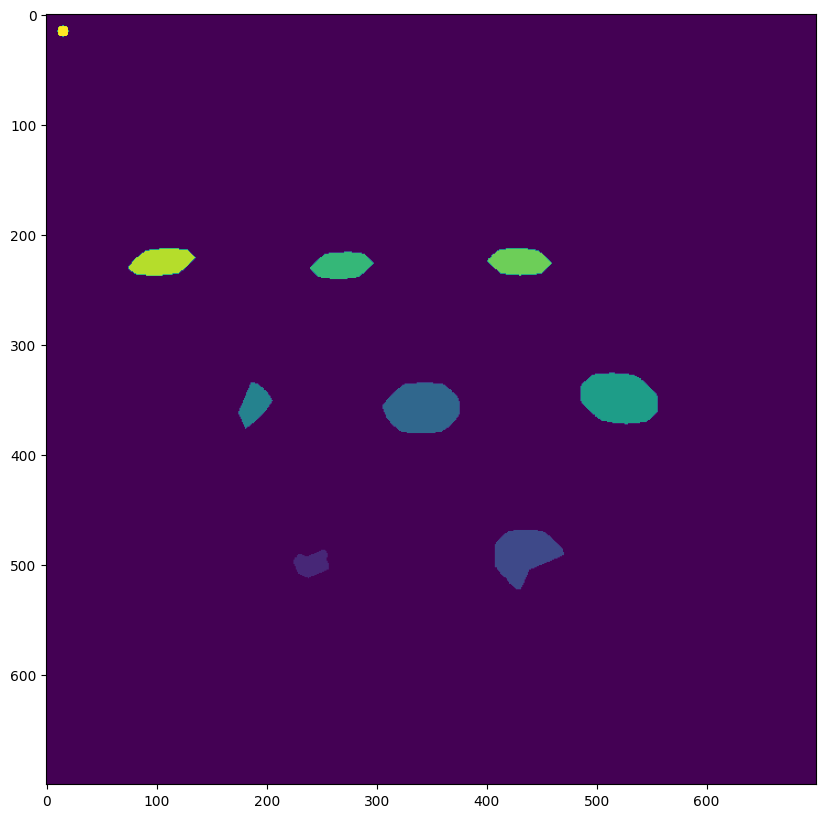

In [7]:
markers = np.zeros(dist1.shape, dtype=np.int32)
dist_8u = dist1.astype('uint8')
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)

markers = cv2.circle(markers, (15, 15), 5, len(contours) + 1, -1)
plt.figure(figsize=(15,10))
plt.imshow(markers)

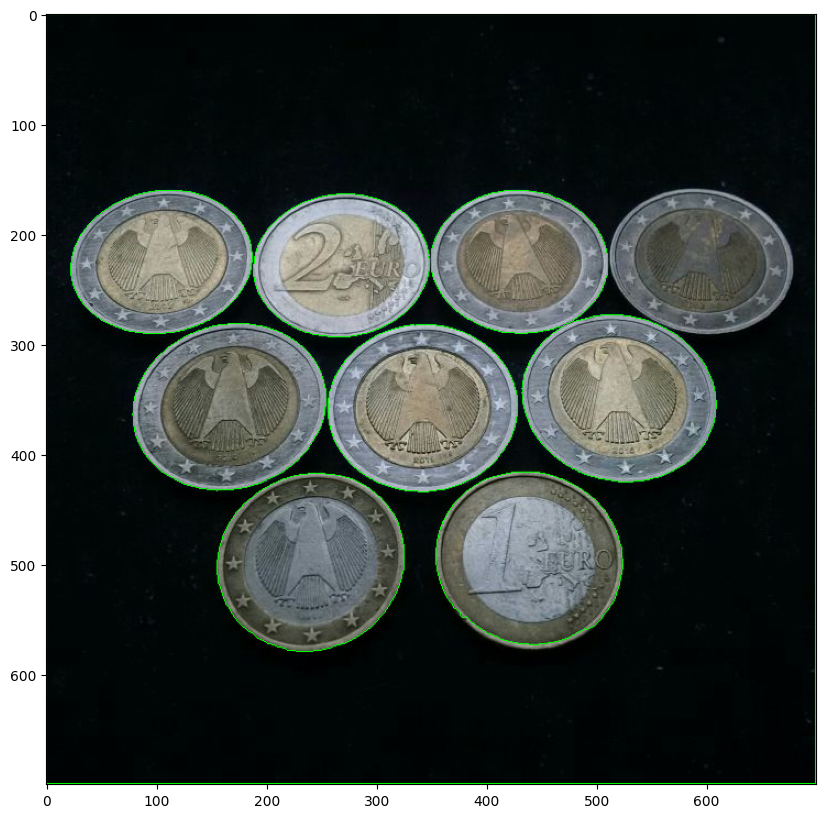

In [8]:
markers = cv2.watershed(img, markers)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img[markers == -1] = [0, 255, 0]

plt.figure(figsize=(15,10))
plt.imshow(img)

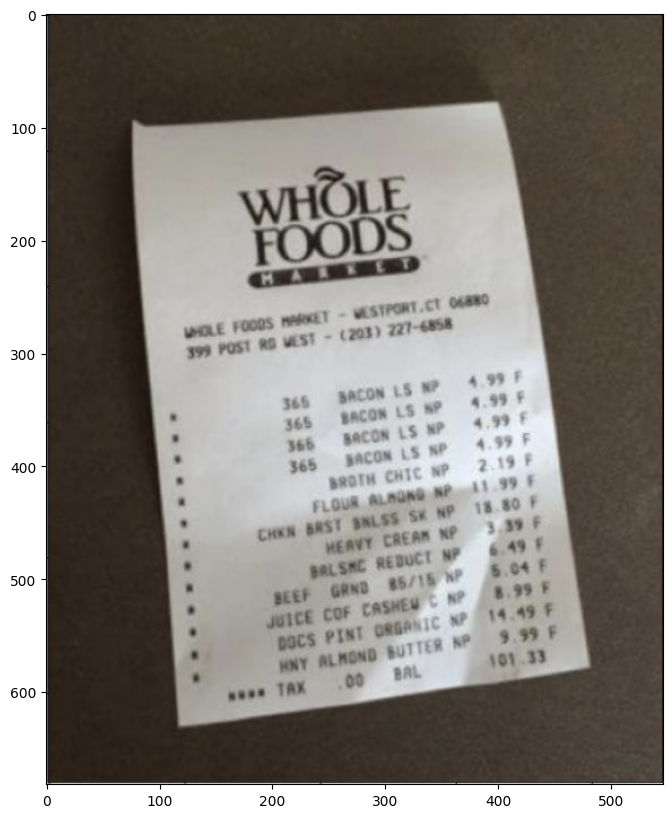

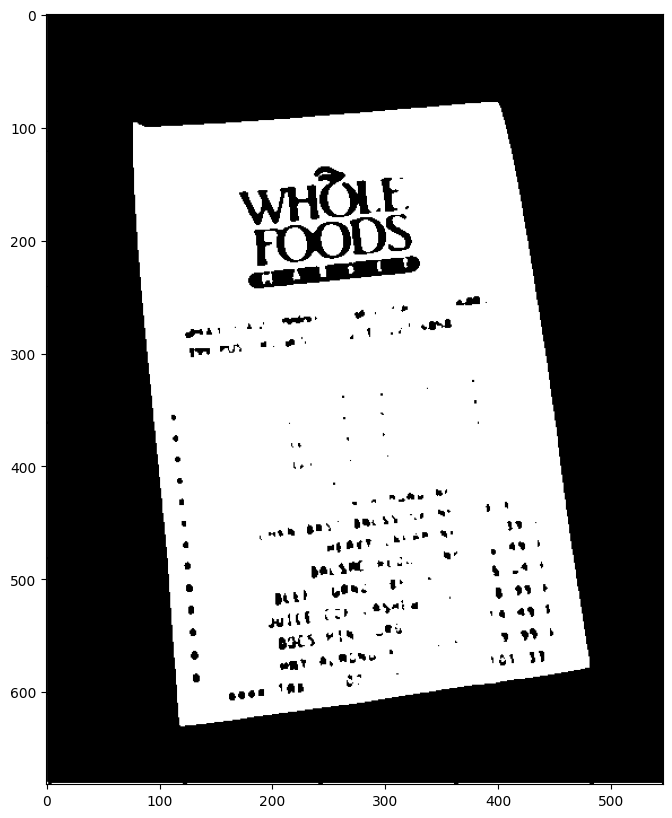

In [9]:
img = cv2.imread('src.jpg')
ratio = img.shape[0] / 500.0
orig = img.copy()


plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

filterd_image  = cv2.GaussianBlur(imgray, (3, 3), 0)

ret, thresh_img = cv2.threshold(filterd_image, 200, 255, cv2.THRESH_OTSU)

plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(thresh_img, cv2.COLOR_BGR2RGB))

contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [10]:
import imutils

contours = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
         screenCnt = approx
    break

In [11]:
from scipy.spatial import distance as dist
import numpy as np
import cv2

def order_points(pts):

    xSorted = pts[np.argsort(pts[:, 0]), :]

    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    return np.array([tl, tr, br, bl], dtype="float32")

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    return warped

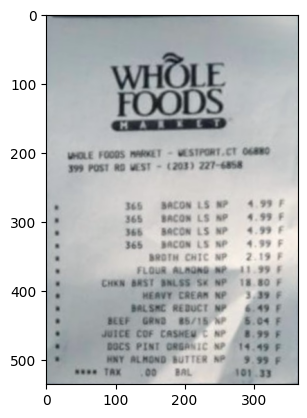

In [12]:
from skimage.filters import threshold_local

warped = four_point_transform(orig, screenCnt.reshape(4, 2))

plt.imshow(warped)
